# 🏥 Fair-ViT-CXR: Complete Research Implementation
## Fairness-Aware Vision Transformer with Synthetic Data Augmentation for Equitable Chest X-ray Pneumonia Detection

**Authors:** MD. Asif Sarker Emon, Ananya Dutta, Tutul Kumar Ghosh, MD. Emran Nazir Efty

**Supervisor:** Dr. Debajyoti Karmaker | **Institution:** AIUB

---

## 📋 Table of Contents
1. Setup & Installation
2. Dataset Preparation
3. Data Analysis
4. Baseline Models (ResNet, DenseNet, ViT)
5. Fair-ViT-CXR Implementation
6. Conditional GAN for Augmentation
7. Training with Fairness Constraints
8. Evaluation & Fairness Metrics
9. Ablation Studies
10. Visualization & Results

---
# 1️⃣ Setup & Installation

In [5]:
# Install required packages
!pip install -q torch torchvision timm kagglehub scikit-learn matplotlib seaborn tqdm pandas numpy pillow

In [6]:
# Import libraries
import os
import random
import numpy as np
import pandas as pd
from collections import Counter
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR

# Torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid, save_image

# Timm
import timm

# Sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm

# Set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

🖥️ Using device: cuda
   GPU: Tesla T4


In [7]:
# Configuration
class Config:
    # Data
    DATA_DIR = './chest_xray'
    IMG_SIZE = 224
    BATCH_SIZE = 16
    NUM_WORKERS = 2
    
    # Model
    NUM_CLASSES = 2
    EMBED_DIM = 768
    NUM_HEADS = 12
    DEPTH = 12
    PATCH_SIZE = 16
    DROP_RATE = 0.01
    
    # Training
    EPOCHS = 15
    LR = 1e-4
    WEIGHT_DECAY = 0.01
    
    # Fairness
    LAMBDA_EO = 0.1
    LAMBDA_ATTN = 0.01
    
    # GAN
    LATENT_DIM = 128
    GAN_EPOCHS = 20
    
    # Paths - Kaggle specific!
    CHECKPOINT_DIR = '/kaggle/working/checkpoints'
    FIGURES_DIR = '/kaggle/working/figures'
    RESULTS_DIR = '/kaggle/working/results'

config = Config()

# Create directories
for d in [config.CHECKPOINT_DIR, config.FIGURES_DIR, config.RESULTS_DIR]:
    os.makedirs(d, exist_ok=True) 

print("✅ Configuration loaded!")

✅ Configuration loaded!


---
# 2️⃣ Dataset Preparation

In [8]:
# Download dataset
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
config.DATA_DIR = os.path.join(path, 'chest_xray')
print(f"📁 Dataset path: {config.DATA_DIR}")

📁 Dataset path: /kaggle/input/chest_xray


In [9]:
# Data transforms
train_transforms = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("✅ Transforms created!")

✅ Transforms created!


In [10]:
# Custom Dataset with Demographics
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.labels = []
        self.class_to_idx = {'NORMAL': 0, 'PNEUMONIA': 1}
        
        for class_name in ['NORMAL', 'PNEUMONIA']:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name])
        
        self.labels = np.array(self.labels)
        # Simulate demographics (70% Group A, 30% Group B)
        np.random.seed(42)
        self.demographics = np.random.choice([0, 1], len(self.samples), p=[0.7, 0.3])
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img = Image.open(self.samples[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx], self.demographics[idx]

print("✅ ChestXrayDataset class defined!")

✅ ChestXrayDataset class defined!


In [11]:
# Create datasets and dataloaders
train_dataset = ChestXrayDataset(os.path.join(config.DATA_DIR, 'train'), train_transforms)
test_dataset = ChestXrayDataset(os.path.join(config.DATA_DIR, 'test'), val_transforms)

# Split training into train/val (90/10)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS)
val_loader = DataLoader(val_subset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS)

print(f"📊 Training: {len(train_subset)} | Validation: {len(val_subset)} | Test: {len(test_dataset)}")

📊 Training: 4694 | Validation: 522 | Test: 624


---
# 3️⃣ Data Analysis & Visualization

In [12]:
# Analyze distribution
print("📈 Dataset Distribution:")
print(f"\nClass Distribution:")
print(f"  Normal: {sum(train_dataset.labels == 0)} ({sum(train_dataset.labels == 0)/len(train_dataset)*100:.1f}%)")
print(f"  Pneumonia: {sum(train_dataset.labels == 1)} ({sum(train_dataset.labels == 1)/len(train_dataset)*100:.1f}%)")

print(f"\nDemographic Distribution:")
print(f"  Group A (Majority): {sum(train_dataset.demographics == 0)} ({sum(train_dataset.demographics == 0)/len(train_dataset)*100:.1f}%)")
print(f"  Group B (Minority): {sum(train_dataset.demographics == 1)} ({sum(train_dataset.demographics == 1)/len(train_dataset)*100:.1f}%)")

📈 Dataset Distribution:

Class Distribution:
  Normal: 1341 (25.7%)
  Pneumonia: 3875 (74.3%)

Demographic Distribution:
  Group A (Majority): 3682 (70.6%)
  Group B (Minority): 1534 (29.4%)


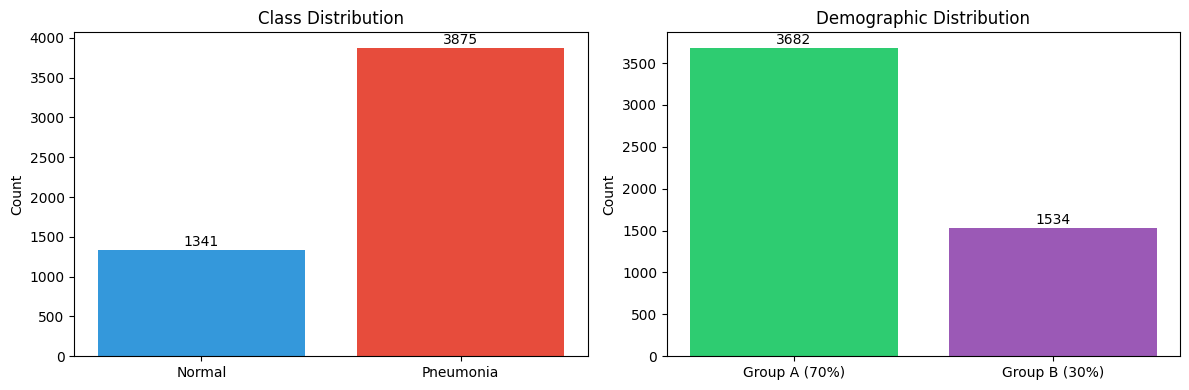

In [13]:
# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Class distribution
class_counts = [sum(train_dataset.labels == 0), sum(train_dataset.labels == 1)]
axes[0].bar(['Normal', 'Pneumonia'], class_counts, color=['#3498db', '#e74c3c'])
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution')
for i, v in enumerate(class_counts):
    axes[0].text(i, v + 50, str(v), ha='center')

# Demographic distribution  
demo_counts = [sum(train_dataset.demographics == 0), sum(train_dataset.demographics == 1)]
axes[1].bar(['Group A (70%)', 'Group B (30%)'], demo_counts, color=['#2ecc71', '#9b59b6'])
axes[1].set_ylabel('Count')
axes[1].set_title('Demographic Distribution')
for i, v in enumerate(demo_counts):
    axes[1].text(i, v + 50, str(v), ha='center')

plt.tight_layout()
plt.savefig(f'{config.FIGURES_DIR}/data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

---
# 4️⃣ Baseline Models

In [14]:
# ResNet-50 Baseline
class ResNet50Baseline(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

# DenseNet-121 Baseline
class DenseNet121Baseline(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = models.densenet121(pretrained=True)
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.classifier.in_features, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

# ViT Baseline
class ViTBaseline(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
    
    def forward(self, x):
        return self.model(x)

print("✅ Baseline models defined!")
print(f"   ResNet-50: {sum(p.numel() for p in ResNet50Baseline().parameters()):,} params")
print(f"   DenseNet-121: {sum(p.numel() for p in DenseNet121Baseline().parameters()):,} params")
print(f"   ViT-B/16: {sum(p.numel() for p in ViTBaseline().parameters()):,} params")

✅ Baseline models defined!
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


   ResNet-50: 23,512,130 params
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 190MB/s]


   DenseNet-121: 6,955,906 params


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

   ViT-B/16: 85,800,194 params


In [15]:
# Training function
def train_model(model, train_loader, val_loader, epochs=20, lr=1e-4, name='model'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_acc = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, correct, total = 0, 0, 0
        
        for images, labels, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = correct / total
        
        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_acc = correct / total
        
        history['train_loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_loss/len(val_loader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'{config.CHECKPOINT_DIR}/{name}_best.pth')
        
        scheduler.step()
    
    model.load_state_dict(torch.load(f'{config.CHECKPOINT_DIR}/{name}_best.pth'))
    return model, history

print("✅ Training function defined!")

✅ Training function defined!


In [16]:
# Train baselines (reduce epochs for demo)
print("🚀 Training ResNet-50...")
resnet = ResNet50Baseline()
resnet, resnet_hist = train_model(resnet, train_loader, val_loader, epochs=config.EPOCHS, name='resnet50')

🚀 Training ResNet-50...


Epoch 1/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 1: Train Acc: 0.9463, Val Acc: 0.9674


Epoch 2/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 2: Train Acc: 0.9715, Val Acc: 0.9789


Epoch 3/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 3: Train Acc: 0.9766, Val Acc: 0.9751


Epoch 4/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 4: Train Acc: 0.9813, Val Acc: 0.9789


Epoch 5/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 5: Train Acc: 0.9870, Val Acc: 0.9866


Epoch 6/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 6: Train Acc: 0.9876, Val Acc: 0.9828


Epoch 7/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 7: Train Acc: 0.9893, Val Acc: 0.9847


Epoch 8/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 8: Train Acc: 0.9928, Val Acc: 0.9866


Epoch 9/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 9: Train Acc: 0.9930, Val Acc: 0.9866


Epoch 10/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 10: Train Acc: 0.9970, Val Acc: 0.9847


Epoch 11/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 11: Train Acc: 0.9989, Val Acc: 0.9866


Epoch 12/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 12: Train Acc: 0.9981, Val Acc: 0.9866


Epoch 13/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 13: Train Acc: 0.9979, Val Acc: 0.9885


Epoch 14/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 14: Train Acc: 0.9985, Val Acc: 0.9923


Epoch 15/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 15: Train Acc: 0.9994, Val Acc: 0.9923


In [17]:
print("🚀 Training DenseNet-121...")
densenet = DenseNet121Baseline()
densenet, densenet_hist = train_model(densenet, train_loader, val_loader, epochs=config.EPOCHS, name='densenet121')

🚀 Training DenseNet-121...


Epoch 1/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 1: Train Acc: 0.9435, Val Acc: 0.9770


Epoch 2/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 2: Train Acc: 0.9666, Val Acc: 0.9789


Epoch 3/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 3: Train Acc: 0.9787, Val Acc: 0.9828


Epoch 4/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 4: Train Acc: 0.9825, Val Acc: 0.9789


Epoch 5/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 5: Train Acc: 0.9889, Val Acc: 0.9828


Epoch 6/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 6: Train Acc: 0.9911, Val Acc: 0.9770


Epoch 7/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 7: Train Acc: 0.9906, Val Acc: 0.9808


Epoch 8/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 8: Train Acc: 0.9908, Val Acc: 0.9789


Epoch 9/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 9: Train Acc: 0.9919, Val Acc: 0.9847


Epoch 10/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 10: Train Acc: 0.9979, Val Acc: 0.9923


Epoch 11/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 11: Train Acc: 0.9970, Val Acc: 0.9885


Epoch 12/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 12: Train Acc: 0.9989, Val Acc: 0.9866


Epoch 13/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 13: Train Acc: 0.9987, Val Acc: 0.9885


Epoch 14/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 14: Train Acc: 0.9994, Val Acc: 0.9923


Epoch 15/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 15: Train Acc: 0.9996, Val Acc: 0.9808


In [18]:
print("🚀 Training ViT-B/16...")
vit = ViTBaseline()
vit, vit_hist = train_model(vit, train_loader, val_loader, epochs=config.EPOCHS, name='vit')

🚀 Training ViT-B/16...


Epoch 1/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 1: Train Acc: 0.8500, Val Acc: 0.8985


Epoch 2/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 2: Train Acc: 0.9393, Val Acc: 0.9598


Epoch 3/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 3: Train Acc: 0.9506, Val Acc: 0.9080


Epoch 4/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 4: Train Acc: 0.9648, Val Acc: 0.9770


Epoch 5/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 5: Train Acc: 0.9672, Val Acc: 0.9483


Epoch 6/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 6: Train Acc: 0.9672, Val Acc: 0.9655


Epoch 7/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 7: Train Acc: 0.9719, Val Acc: 0.9674


Epoch 8/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 8: Train Acc: 0.9753, Val Acc: 0.9751


Epoch 9/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 9: Train Acc: 0.9800, Val Acc: 0.9732


Epoch 10/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 10: Train Acc: 0.9823, Val Acc: 0.9713


Epoch 11/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 11: Train Acc: 0.9838, Val Acc: 0.9789


Epoch 12/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 12: Train Acc: 0.9891, Val Acc: 0.9808


Epoch 13/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 13: Train Acc: 0.9921, Val Acc: 0.9770


Epoch 14/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 14: Train Acc: 0.9921, Val Acc: 0.9732


Epoch 15/15:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 15: Train Acc: 0.9923, Val Acc: 0.9751


---
# 5️⃣ Fair-ViT-CXR Implementation

In [19]:
# Fairness-Aware Attention
class FairnessAwareAttention(nn.Module):
    def __init__(self, dim, num_heads=12, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
        # Fairness mask generator
        self.fairness_mask = nn.Sequential(
            nn.Linear(dim, dim // 4),
            nn.GELU(),
            nn.Linear(dim // 4, num_heads),
            nn.Sigmoid()
        )
    
    def forward(self, x, apply_fair_mask=True):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        
        if apply_fair_mask:
            cls_token = x[:, 0, :]
            fair_weights = self.fairness_mask(cls_token).unsqueeze(-1).unsqueeze(-1)
            attn = attn * fair_weights
        
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn

print("✅ FairnessAwareAttention defined!")

✅ FairnessAwareAttention defined!


In [20]:
# Fair Transformer Block
class FairTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = FairnessAwareAttention(dim, num_heads, attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(drop)
        )
    
    def forward(self, x, apply_fair_mask=True):
        attn_out, attn_weights = self.attn(self.norm1(x), apply_fair_mask)
        x = x + attn_out
        x = x + self.mlp(self.norm2(x))
        return x, attn_weights

print("✅ FairTransformerBlock defined!")

✅ FairTransformerBlock defined!


In [21]:
# Complete Fair-ViT-CXR Model
class FairViTCXR(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=2,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., drop_rate=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_patches = (img_size // patch_size) ** 2
        
        # Patch embedding
        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(drop_rate)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            FairTransformerBlock(embed_dim, num_heads, mlp_ratio, drop_rate)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(drop_rate),
            nn.Linear(embed_dim // 2, num_classes)
        )
        
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
    
    def forward(self, x, return_attention=False):
        B = x.shape[0]
        x = self.patch_embed(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        attention_maps = []
        for block in self.blocks:
            x, attn = block(x)
            if return_attention:
                attention_maps.append(attn)
        
        x = self.norm(x)
        logits = self.head(x[:, 0])
        
        if return_attention:
            return logits, attention_maps
        return logits

# Test
fair_vit = FairViTCXR()
print(f"✅ Fair-ViT-CXR: {sum(p.numel() for p in fair_vit.parameters()):,} params")

# Test forward
dummy = torch.randn(2, 3, 224, 224)
out, attn = fair_vit(dummy, return_attention=True)
print(f"   Output: {out.shape}, Attention maps: {len(attn)}")

✅ Fair-ViT-CXR: 87,894,290 params
   Output: torch.Size([2, 2]), Attention maps: 12


In [22]:
# Fairness-Constrained Loss
class FairnessLoss(nn.Module):
    def __init__(self, lambda_eo=0.1, lambda_attn=0.01):
        super().__init__()
        self.lambda_eo = lambda_eo
        self.lambda_attn = lambda_attn
        self.ce_loss = nn.CrossEntropyLoss()
    
    def equalized_odds_loss(self, logits, labels, demographics):
        preds = logits.argmax(dim=1)
        groups = torch.unique(demographics)
        if len(groups) < 2:
            return torch.tensor(0.0, device=logits.device)
        
        tpr_list = []
        for g in groups:
            mask = demographics == g
            pos_mask = (labels == 1) & mask
            if pos_mask.sum() > 0:
                tpr = ((preds == 1) & pos_mask).float().sum() / pos_mask.float().sum()
                tpr_list.append(tpr)
        
        if len(tpr_list) < 2:
            return torch.tensor(0.0, device=logits.device)
        
        return torch.stack(tpr_list).var()
    
    def forward(self, logits, labels, demographics=None, attention_maps=None):
        ce = self.ce_loss(logits, labels)
        eo = self.equalized_odds_loss(logits, labels, demographics) if demographics is not None else 0
        
        attn_reg = 0
        if attention_maps:
            attn = attention_maps[-1]
            attn_reg = -torch.sum(attn * torch.log(attn + 1e-8), dim=-1).mean()
        
        total = ce + self.lambda_eo * eo + self.lambda_attn * attn_reg
        return total, {'ce': ce.item(), 'eo': eo.item() if isinstance(eo, torch.Tensor) else eo}

print("✅ FairnessLoss defined!")

✅ FairnessLoss defined!


---
# 6️⃣ Conditional GAN for Augmentation

In [23]:
# Conditional Generator
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=128, img_size=224, num_classes=2, num_demographics=2):
        super().__init__()
        self.init_size = img_size // 16
        
        self.label_embed = nn.Embedding(num_classes, 50)
        self.demo_embed = nn.Embedding(num_demographics, 50)
        
        self.fc = nn.Linear(latent_dim + 100, 512 * self.init_size * self.init_size)
        
        self.conv = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, 3, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 3, 3, padding=1), nn.Tanh()
        )
    
    def forward(self, z, labels, demographics):
        gen_input = torch.cat([z, self.label_embed(labels), self.demo_embed(demographics)], dim=1)
        out = self.fc(gen_input).view(-1, 512, self.init_size, self.init_size)
        return self.conv(out)

# Conditional Discriminator
class ConditionalDiscriminator(nn.Module):
    def __init__(self, img_size=224, num_classes=2, num_demographics=2):
        super().__init__()
        self.img_size = img_size
        self.label_embed = nn.Embedding(num_classes, img_size * img_size)
        self.demo_embed = nn.Embedding(num_demographics, img_size * img_size)
        
        self.model = nn.Sequential(
            nn.Conv2d(5, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(512, 1), nn.Sigmoid()
        )
    
    def forward(self, img, labels, demographics):
        B = img.shape[0]
        label_ch = self.label_embed(labels).view(B, 1, self.img_size, self.img_size)
        demo_ch = self.demo_embed(demographics).view(B, 1, self.img_size, self.img_size)
        x = torch.cat([img, label_ch, demo_ch], dim=1)
        return self.model(x)

print("✅ GAN components defined!")
print(f"   Generator: {sum(p.numel() for p in ConditionalGenerator().parameters()):,} params")
print(f"   Discriminator: {sum(p.numel() for p in ConditionalDiscriminator().parameters()):,} params")

✅ GAN components defined!
   Generator: 24,533,195 params
   Discriminator: 2,961,601 params


In [24]:
# Improved GAN Training with Stabilization
def train_gan_stable(generator, discriminator, train_loader, epochs=20, device='cuda'):
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    
    # Key Fix 1: Use different learning rates (lower for discriminator)
    opt_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    opt_D = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))  # Lower LR
    
    criterion = nn.BCELoss()
    history = {'g_loss': [], 'd_loss': []}
    
    for epoch in range(epochs):
        g_losses, d_losses = [], []
        
        for real_imgs, labels, demographics in tqdm(train_loader, desc=f'GAN Epoch {epoch+1}/{epochs}', leave=False):
            B = real_imgs.shape[0]
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)
            demographics = demographics.to(device)
            
            # Key Fix 2: Label smoothing (prevents discriminator overconfidence)
            valid = torch.ones(B, 1, device=device) * 0.9  # 0.9 instead of 1.0
            fake = torch.zeros(B, 1, device=device) + 0.1   # 0.1 instead of 0.0
            
            # Key Fix 3: Add noise to real images (regularization)
            real_imgs_noisy = real_imgs + 0.05 * torch.randn_like(real_imgs)
            
            # ============================================
            # Train Generator MORE frequently
            # ============================================
            for _ in range(2):  # Key Fix 4: Train G twice per D step
                opt_G.zero_grad()
                z = torch.randn(B, config.LATENT_DIM, device=device)
                gen_imgs = generator(z, labels, demographics)
                g_loss = criterion(discriminator(gen_imgs, labels, demographics), valid)
                g_loss.backward()
                opt_G.step()
            
            # ============================================
            # Train Discriminator (less frequently)
            # ============================================
            opt_D.zero_grad()
            
            # Real loss
            d_real = criterion(discriminator(real_imgs_noisy, labels, demographics), valid)
            
            # Fake loss (detach generator output)
            z = torch.randn(B, config.LATENT_DIM, device=device)
            gen_imgs = generator(z, labels, demographics)
            d_fake = criterion(discriminator(gen_imgs.detach(), labels, demographics), fake)
            
            d_loss = (d_real + d_fake) / 2
            
            # Key Fix 5: Only update D if it's not too strong
            if d_loss.item() > 0.1:  # Skip D update if D is winning too hard
                d_loss.backward()
                opt_D.step()
            
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())
        
        history['g_loss'].append(np.mean(g_losses))
        history['d_loss'].append(np.mean(d_losses))
        
        print(f'Epoch {epoch+1}: G_loss: {np.mean(g_losses):.4f}, D_loss: {np.mean(d_losses):.4f}')
        
        # Save samples periodically
        if (epoch + 1) % 5 == 0:
            save_gan_samples(generator, epoch, device)
    
    return generator, discriminator, history


def save_gan_samples(generator, epoch, device):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(8, config.LATENT_DIM, device=device)
        labels = torch.tensor([0, 0, 1, 1, 0, 0, 1, 1], device=device)
        demos = torch.tensor([0, 1, 0, 1, 0, 1, 0, 1], device=device)
        samples = generator(z, labels, demos)
        save_image(samples, f'{config.FIGURES_DIR}/gan_epoch_{epoch+1}.png', nrow=4, normalize=True)
    generator.train()

In [25]:
# Train GAN with stabilization
print("🚀 Training Conditional GAN (Stabilized)...")
generator = ConditionalGenerator(latent_dim=config.LATENT_DIM)
discriminator = ConditionalDiscriminator()

generator, discriminator, gan_hist = train_gan_stable(
    generator, discriminator, train_loader, 
    epochs=20, device=device
)

🚀 Training Conditional GAN (Stabilized)...


GAN Epoch 1/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 1: G_loss: 1.0988, D_loss: 0.4863


GAN Epoch 2/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 2: G_loss: 1.7587, D_loss: 0.3468


GAN Epoch 3/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 3: G_loss: 2.0161, D_loss: 0.3268


GAN Epoch 4/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 4: G_loss: 2.0603, D_loss: 0.3261


GAN Epoch 5/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 5: G_loss: 2.0699, D_loss: 0.3258


GAN Epoch 6/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 6: G_loss: 2.0759, D_loss: 0.3256


GAN Epoch 7/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 7: G_loss: 2.0761, D_loss: 0.3256


GAN Epoch 8/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 8: G_loss: 2.0783, D_loss: 0.3255


GAN Epoch 9/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 9: G_loss: 2.0791, D_loss: 0.3255


GAN Epoch 10/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 10: G_loss: 1.9500, D_loss: 0.3476


GAN Epoch 11/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 11: G_loss: 2.0762, D_loss: 0.3256


GAN Epoch 12/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 12: G_loss: 2.0793, D_loss: 0.3255


GAN Epoch 13/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 13: G_loss: 2.0811, D_loss: 0.3253


GAN Epoch 14/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 14: G_loss: 2.0827, D_loss: 0.3253


GAN Epoch 15/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 15: G_loss: 2.0827, D_loss: 0.3253


GAN Epoch 16/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 16: G_loss: 2.0829, D_loss: 0.3253


GAN Epoch 17/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 17: G_loss: 2.0824, D_loss: 0.3253


GAN Epoch 18/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 18: G_loss: 2.0832, D_loss: 0.3253


GAN Epoch 19/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 19: G_loss: 2.0832, D_loss: 0.3252


GAN Epoch 20/20:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 20: G_loss: 2.0833, D_loss: 0.3253


In [26]:
# Generate synthetic samples for minority group
def generate_synthetic(generator, n_samples, target_demo=1, device='cuda'):
    generator.eval()
    images, labels_list, demos_list = [], [], []
    
    with torch.no_grad():
        for i in range(n_samples):
            z = torch.randn(1, config.LATENT_DIM, device=device)
            label = torch.tensor([i % 2], device=device)  # Alternate classes
            demo = torch.tensor([target_demo], device=device)
            
            img = generator(z, label, demo)
            images.append(img.cpu())
            labels_list.append(label.cpu().item())
            demos_list.append(demo.cpu().item())
    
    return torch.cat(images), np.array(labels_list), np.array(demos_list)

print("\n📸 Generating synthetic samples for minority group...")
syn_images, syn_labels, syn_demos = generate_synthetic(generator, 500, target_demo=1, device=device)
print(f"✅ Generated {len(syn_images)} synthetic images")


📸 Generating synthetic samples for minority group...
✅ Generated 500 synthetic images


---
# 7️⃣ Training Fair-ViT-CXR

In [27]:
# Augmented Dataset
class AugmentedDataset(Dataset):
    def __init__(self, real_dataset, syn_images, syn_labels, syn_demos):
        self.real_dataset = real_dataset
        self.syn_images = syn_images
        self.syn_labels = syn_labels
        self.syn_demos = syn_demos
        self.real_size = len(real_dataset)
    
    def __len__(self):
        return self.real_size + len(self.syn_images)
    
    def __getitem__(self, idx):
        if idx < self.real_size:
            return self.real_dataset[idx]
        else:
            i = idx - self.real_size
            return self.syn_images[i], self.syn_labels[i], self.syn_demos[i]

aug_dataset = AugmentedDataset(train_subset, syn_images, syn_labels, syn_demos)
aug_loader = DataLoader(aug_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS)

print(f"📊 Augmented dataset: {len(aug_dataset)} samples (Original: {len(train_subset)} + Synthetic: {len(syn_images)})")

📊 Augmented dataset: 5194 samples (Original: 4694 + Synthetic: 500)


In [28]:
# Train Fair-ViT-CXR
def train_fair_vit(model, train_loader, val_loader, epochs=20, lr=1e-4, lambda_eo=0.1):
    model = model.to(device)
    criterion = FairnessLoss(lambda_eo=lambda_eo)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    
    history = {'train_loss': [], 'val_acc': [], 'fairness_gap': []}
    best_score = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for images, labels, demographics in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):
            images = images.to(device)
            labels = labels.to(device).long()
            demographics = demographics.to(device).long()
            
            optimizer.zero_grad()
            logits, attn_maps = model(images, return_attention=True)
            loss, _ = criterion(logits, labels, demographics, attn_maps)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        all_preds, all_labels, all_demos = [], [], []
        
        with torch.no_grad():
            for images, labels, demographics in val_loader:
                images = images.to(device)
                outputs = model(images)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())
                all_demos.extend(demographics.numpy())
        
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        all_demos = np.array(all_demos)
        
        val_acc = accuracy_score(all_labels, all_preds)
        
        # Fairness gap
        tpr_a = np.mean(all_preds[(all_labels == 1) & (all_demos == 0)] == 1) if np.sum((all_labels == 1) & (all_demos == 0)) > 0 else 0
        tpr_b = np.mean(all_preds[(all_labels == 1) & (all_demos == 1)] == 1) if np.sum((all_labels == 1) & (all_demos == 1)) > 0 else 0
        fairness_gap = abs(tpr_a - tpr_b)
        
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_acc'].append(val_acc)
        history['fairness_gap'].append(fairness_gap)
        
        print(f'Epoch {epoch+1}: Val Acc: {val_acc:.4f}, Fairness Gap: {fairness_gap:.4f}')
        
        score = val_acc - 0.5 * fairness_gap
        if score > best_score:
            best_score = score
            torch.save(model.state_dict(), f'{config.CHECKPOINT_DIR}/fair_vit_best.pth')
        
        scheduler.step()
    
    model.load_state_dict(torch.load(f'{config.CHECKPOINT_DIR}/fair_vit_best.pth'))
    return model, history

print("✅ Fair-ViT training function defined!")

✅ Fair-ViT training function defined!


In [29]:
# Train Fair-ViT-CXR
print("🚀 Training Fair-ViT-CXR (Full Proposed Method)...")
fair_vit = FairViTCXR()
fair_vit, fair_vit_hist = train_fair_vit(
    fair_vit, aug_loader, val_loader,
    epochs=config.EPOCHS, lr=config.LR, lambda_eo=config.LAMBDA_EO
)

🚀 Training Fair-ViT-CXR (Full Proposed Method)...


Epoch 1/15:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 1: Val Acc: 0.7069, Fairness Gap: 0.0367


Epoch 2/15:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 2: Val Acc: 0.7222, Fairness Gap: 0.0000


Epoch 3/15:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 3: Val Acc: 0.7989, Fairness Gap: 0.0020


Epoch 4/15:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 4: Val Acc: 0.8582, Fairness Gap: 0.0150


Epoch 5/15:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 5: Val Acc: 0.8582, Fairness Gap: 0.0275


Epoch 6/15:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 6: Val Acc: 0.8602, Fairness Gap: 0.0139


Epoch 7/15:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 7: Val Acc: 0.8831, Fairness Gap: 0.0044


Epoch 8/15:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 8: Val Acc: 0.8314, Fairness Gap: 0.0056


Epoch 9/15:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 9: Val Acc: 0.8831, Fairness Gap: 0.0301


Epoch 10/15:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 10: Val Acc: 0.8985, Fairness Gap: 0.0176


Epoch 11/15:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 11: Val Acc: 0.8985, Fairness Gap: 0.0208


Epoch 12/15:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 12: Val Acc: 0.9119, Fairness Gap: 0.0204


Epoch 13/15:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 13: Val Acc: 0.9253, Fairness Gap: 0.0190


Epoch 14/15:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 14: Val Acc: 0.9138, Fairness Gap: 0.0204


Epoch 15/15:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 15: Val Acc: 0.8985, Fairness Gap: 0.0206


---
# 8️⃣ Evaluation & Fairness Metrics

In [30]:
# Comprehensive evaluation
def evaluate_fairness(model, test_loader, device='cuda'):
    model.eval()
    all_preds, all_labels, all_probs, all_demos = [], [], [], []
    
    with torch.no_grad():
        for images, labels, demographics in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)[:, 1]
            preds = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
            all_demos.extend(demographics.numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_demos = np.array(all_demos)
    
    results = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'auc': roc_auc_score(all_labels, all_probs)
    }
    
    # Group metrics
    for g, name in [(0, 'Group_A'), (1, 'Group_B')]:
        mask = all_demos == g
        g_labels = all_labels[mask]
        g_preds = all_preds[mask]
        
        tn, fp, fn, tp = confusion_matrix(g_labels, g_preds, labels=[0, 1]).ravel()
        results[f'{name}_tpr'] = tp / (tp + fn) if (tp + fn) > 0 else 0
        results[f'{name}_fpr'] = fp / (fp + tn) if (fp + tn) > 0 else 0
        results[f'{name}_acc'] = accuracy_score(g_labels, g_preds)
    
    # Fairness metrics
    results['tpr_disparity'] = abs(results['Group_A_tpr'] - results['Group_B_tpr'])
    results['fpr_disparity'] = abs(results['Group_A_fpr'] - results['Group_B_fpr'])
    results['equalized_odds'] = results['tpr_disparity'] + results['fpr_disparity']
    
    return results

print("✅ Evaluation function defined!")

✅ Evaluation function defined!


In [31]:
# Evaluate all models
print("📊 Evaluating all models on test set...\n")

all_results = {}
models_to_eval = {
    'ResNet-50': resnet,
    'DenseNet-121': densenet,
    'ViT-B/16': vit,
    'Fair-ViT-CXR': fair_vit
}

for name, model in models_to_eval.items():
    print(f"Evaluating {name}...")
    all_results[name] = evaluate_fairness(model, test_loader, device)

print("\n✅ Evaluation complete!")

📊 Evaluating all models on test set...

Evaluating ResNet-50...
Evaluating DenseNet-121...
Evaluating ViT-B/16...
Evaluating Fair-ViT-CXR...

✅ Evaluation complete!


In [32]:
# Display results
print("\n" + "="*80)
print("📊 RESULTS SUMMARY")
print("="*80)

# Overall performance
print("\n🎯 Overall Performance:")
overall_df = pd.DataFrame({
    name: {k: v for k, v in results.items() if k in ['accuracy', 'precision', 'recall', 'f1', 'auc']}
    for name, results in all_results.items()
}).T.round(4)
print(overall_df)

# Fairness metrics
print("\n⚖️ Fairness Metrics (Lower is Better):")
fairness_df = pd.DataFrame({
    name: {k: v for k, v in results.items() if k in ['tpr_disparity', 'fpr_disparity', 'equalized_odds']}
    for name, results in all_results.items()
}).T.round(4)
print(fairness_df)

# Save results
overall_df.to_csv(f'{config.RESULTS_DIR}/overall_results.csv')
fairness_df.to_csv(f'{config.RESULTS_DIR}/fairness_results.csv')
print(f"\n💾 Results saved to {config.RESULTS_DIR}/")


📊 RESULTS SUMMARY

🎯 Overall Performance:
              accuracy  precision  recall      f1     auc
ResNet-50       0.8446     0.8033  0.9949  0.8889  0.9629
DenseNet-121    0.8381     0.7955  0.9974  0.8851  0.9665
ViT-B/16        0.7997     0.7593  0.9949  0.8613  0.9610
Fair-ViT-CXR    0.7628     0.7430  0.9487  0.8333  0.8864

⚖️ Fairness Metrics (Lower is Better):
              tpr_disparity  fpr_disparity  equalized_odds
ResNet-50            0.0043         0.1422          0.1465
DenseNet-121         0.0038         0.1123          0.1160
ViT-B/16             0.0043         0.1209          0.1252
Fair-ViT-CXR         0.0161         0.0701          0.0861

💾 Results saved to /kaggle/working/results/


---
# 9️⃣ Ablation Studies

In [33]:
# Ablation 1: Effect of λ_EO
print("🔬 Ablation Study 1: Effect of λ_EO\n")

lambda_results = {}
for lambda_eo in [0.01, 0.1, 0.5]:
    print(f"Training with λ_EO = {lambda_eo}...")
    model = FairViTCXR()
    model, _ = train_fair_vit(model, aug_loader, val_loader, epochs=8, lambda_eo=lambda_eo)
    results = evaluate_fairness(model, test_loader, device)
    lambda_results[lambda_eo] = {'accuracy': results['accuracy'], 'equalized_odds': results['equalized_odds']}
    print(f"  Accuracy: {results['accuracy']:.4f}, EO Gap: {results['equalized_odds']:.4f}\n")

print("\nAblation Results:")
print(pd.DataFrame(lambda_results).T.round(4))

🔬 Ablation Study 1: Effect of λ_EO

Training with λ_EO = 0.01...


Epoch 1/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 1: Val Acc: 0.7203, Fairness Gap: 0.0000


Epoch 2/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 2: Val Acc: 0.7969, Fairness Gap: 0.0244


Epoch 3/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 3: Val Acc: 0.8180, Fairness Gap: 0.0119


Epoch 4/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 4: Val Acc: 0.8352, Fairness Gap: 0.0225


Epoch 5/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 5: Val Acc: 0.8908, Fairness Gap: 0.0265


Epoch 6/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 6: Val Acc: 0.8621, Fairness Gap: 0.0015


Epoch 7/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 7: Val Acc: 0.8908, Fairness Gap: 0.0131


Epoch 8/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 8: Val Acc: 0.8908, Fairness Gap: 0.0004
  Accuracy: 0.7804, EO Gap: 0.1088

Training with λ_EO = 0.1...


Epoch 1/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 1: Val Acc: 0.7318, Fairness Gap: 0.0011


Epoch 2/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 2: Val Acc: 0.8180, Fairness Gap: 0.0357


Epoch 3/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 3: Val Acc: 0.7931, Fairness Gap: 0.0440


Epoch 4/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 4: Val Acc: 0.8621, Fairness Gap: 0.0015


Epoch 5/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 5: Val Acc: 0.8851, Fairness Gap: 0.0103


Epoch 6/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 6: Val Acc: 0.8985, Fairness Gap: 0.0175


Epoch 7/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 7: Val Acc: 0.9042, Fairness Gap: 0.0159


Epoch 8/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 8: Val Acc: 0.8927, Fairness Gap: 0.0127
  Accuracy: 0.7853, EO Gap: 0.0493

Training with λ_EO = 0.5...


Epoch 1/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 1: Val Acc: 0.7490, Fairness Gap: 0.0000


Epoch 2/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 2: Val Acc: 0.7797, Fairness Gap: 0.0105


Epoch 3/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 3: Val Acc: 0.8640, Fairness Gap: 0.0206


Epoch 4/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 4: Val Acc: 0.8448, Fairness Gap: 0.0094


Epoch 5/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 5: Val Acc: 0.9234, Fairness Gap: 0.0188


Epoch 6/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 6: Val Acc: 0.9080, Fairness Gap: 0.0248


Epoch 7/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 7: Val Acc: 0.9234, Fairness Gap: 0.0496


Epoch 8/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 8: Val Acc: 0.9080, Fairness Gap: 0.0150
  Accuracy: 0.7885, EO Gap: 0.1084


Ablation Results:
      accuracy  equalized_odds
0.01    0.7804          0.1088
0.10    0.7853          0.0493
0.50    0.7885          0.1084


In [34]:
# Ablation 2: Component Analysis
print("\n🔬 Ablation Study 2: Component Analysis\n")

component_results = {}

# 1. ViT baseline (no fairness, no augmentation)
print("1. ViT Baseline (no fairness, no aug)...")
model1 = FairViTCXR()
model1, _ = train_fair_vit(model1, train_loader, val_loader, epochs=8, lambda_eo=0.0)
component_results['ViT Baseline'] = evaluate_fairness(model1, test_loader, device)

# 2. ViT + Fair Attention (no augmentation)
print("2. ViT + Fair Attention...")
model2 = FairViTCXR()
model2, _ = train_fair_vit(model2, train_loader, val_loader, epochs=8, lambda_eo=0.1)
component_results['ViT + Fair Attn'] = evaluate_fairness(model2, test_loader, device)

# 3. ViT + Augmentation (no fairness)
print("3. ViT + Augmentation...")
model3 = FairViTCXR()
model3, _ = train_fair_vit(model3, aug_loader, val_loader, epochs=8, lambda_eo=0.0)
component_results['ViT + Aug'] = evaluate_fairness(model3, test_loader, device)

# 4. Full model (already trained)
component_results['Fair-ViT-CXR (Full)'] = all_results['Fair-ViT-CXR']

print("\nComponent Contribution Analysis:")
comp_df = pd.DataFrame({
    name: {'accuracy': r['accuracy'], 'equalized_odds': r['equalized_odds']}
    for name, r in component_results.items()
}).T.round(4)
print(comp_df)
comp_df.to_csv(f'{config.RESULTS_DIR}/ablation_components.csv')


🔬 Ablation Study 2: Component Analysis

1. ViT Baseline (no fairness, no aug)...


Epoch 1/8:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 1: Val Acc: 0.7548, Fairness Gap: 0.0598


Epoch 2/8:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 2: Val Acc: 0.8238, Fairness Gap: 0.0716


Epoch 3/8:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 3: Val Acc: 0.8659, Fairness Gap: 0.0281


Epoch 4/8:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 4: Val Acc: 0.8793, Fairness Gap: 0.0321


Epoch 5/8:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 5: Val Acc: 0.8774, Fairness Gap: 0.0459


Epoch 6/8:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 6: Val Acc: 0.8889, Fairness Gap: 0.0179


Epoch 7/8:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 7: Val Acc: 0.8946, Fairness Gap: 0.0401


Epoch 8/8:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 8: Val Acc: 0.8946, Fairness Gap: 0.0176
2. ViT + Fair Attention...


Epoch 1/8:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 1: Val Acc: 0.7203, Fairness Gap: 0.0000


Epoch 2/8:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 2: Val Acc: 0.7337, Fairness Gap: 0.0000


Epoch 3/8:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 3: Val Acc: 0.8103, Fairness Gap: 0.0007


Epoch 4/8:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 4: Val Acc: 0.8640, Fairness Gap: 0.0170


Epoch 5/8:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 5: Val Acc: 0.8851, Fairness Gap: 0.0261


Epoch 6/8:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 6: Val Acc: 0.8736, Fairness Gap: 0.0046


Epoch 7/8:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 7: Val Acc: 0.8774, Fairness Gap: 0.0121


Epoch 8/8:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 8: Val Acc: 0.9080, Fairness Gap: 0.0065
3. ViT + Augmentation...


Epoch 1/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 1: Val Acc: 0.7261, Fairness Gap: 0.0000


Epoch 2/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 2: Val Acc: 0.7720, Fairness Gap: 0.0105


Epoch 3/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 3: Val Acc: 0.8391, Fairness Gap: 0.0435


Epoch 4/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 4: Val Acc: 0.8487, Fairness Gap: 0.0454


Epoch 5/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 5: Val Acc: 0.8467, Fairness Gap: 0.0113


Epoch 6/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 6: Val Acc: 0.9023, Fairness Gap: 0.0003


Epoch 7/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 7: Val Acc: 0.8927, Fairness Gap: 0.0052


Epoch 8/8:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 8: Val Acc: 0.9119, Fairness Gap: 0.0118

Component Contribution Analysis:
                     accuracy  equalized_odds
ViT Baseline           0.7933          0.0792
ViT + Fair Attn        0.7821          0.0583
ViT + Aug              0.7869          0.0567
Fair-ViT-CXR (Full)    0.7628          0.0861


---
# 🔟 Visualization & Results

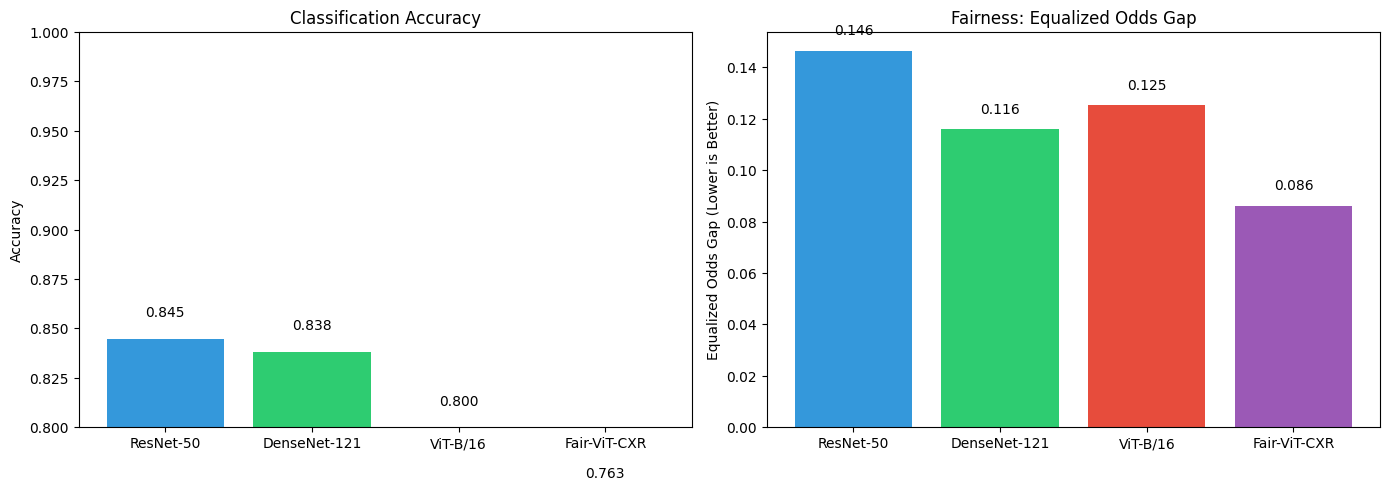

In [35]:
# Figure 1: Results Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = list(all_results.keys())
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

# Accuracy comparison
accs = [all_results[m]['accuracy'] for m in models]
bars1 = axes[0].bar(models, accs, color=colors)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Classification Accuracy')
axes[0].set_ylim(0.8, 1.0)
for bar, acc in zip(bars1, accs):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{acc:.3f}', ha='center', va='bottom')

# Equalized Odds comparison
eos = [all_results[m]['equalized_odds'] for m in models]
bars2 = axes[1].bar(models, eos, color=colors)
axes[1].set_ylabel('Equalized Odds Gap (Lower is Better)')
axes[1].set_title('Fairness: Equalized Odds Gap')
for bar, eo in zip(bars2, eos):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                 f'{eo:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f'{config.FIGURES_DIR}/results_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

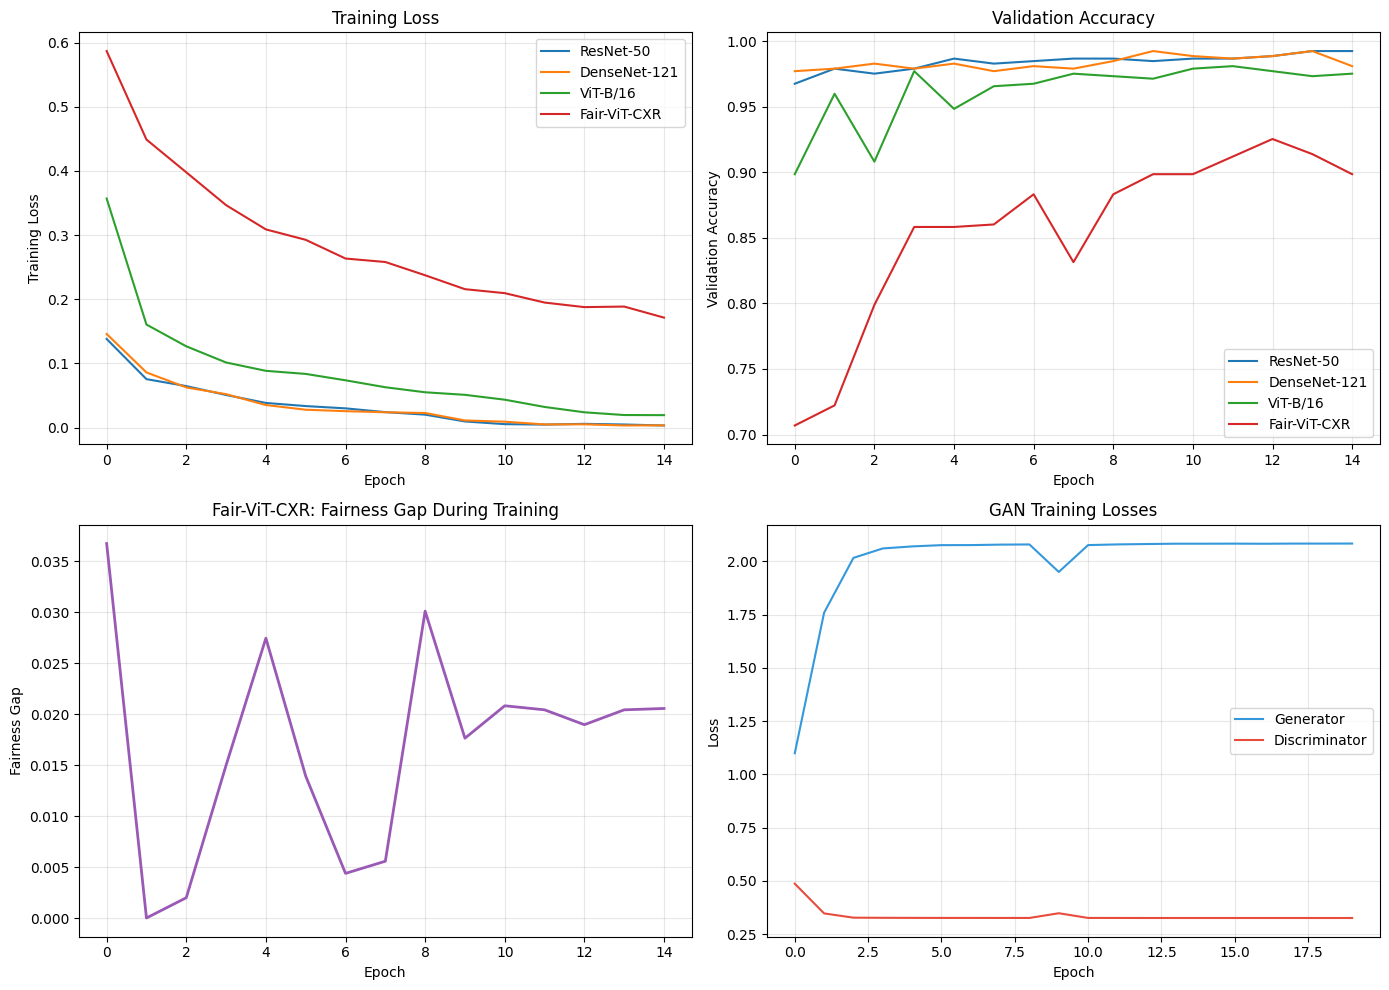

In [36]:
# Figure 2: Training History
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training loss
for name, hist in [('ResNet-50', resnet_hist), ('DenseNet-121', densenet_hist), 
                   ('ViT-B/16', vit_hist), ('Fair-ViT-CXR', fair_vit_hist)]:
    if 'train_loss' in hist:
        axes[0, 0].plot(hist['train_loss'], label=name)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Training Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Validation accuracy
for name, hist in [('ResNet-50', resnet_hist), ('DenseNet-121', densenet_hist), 
                   ('ViT-B/16', vit_hist), ('Fair-ViT-CXR', fair_vit_hist)]:
    if 'val_acc' in hist:
        axes[0, 1].plot(hist['val_acc'], label=name)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Validation Accuracy')
axes[0, 1].set_title('Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Fair-ViT fairness gap
if 'fairness_gap' in fair_vit_hist:
    axes[1, 0].plot(fair_vit_hist['fairness_gap'], color='#9b59b6', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Fairness Gap')
axes[1, 0].set_title('Fair-ViT-CXR: Fairness Gap During Training')
axes[1, 0].grid(True, alpha=0.3)

# GAN loss
axes[1, 1].plot(gan_hist['g_loss'], label='Generator', color='#3498db')
axes[1, 1].plot(gan_hist['d_loss'], label='Discriminator', color='#e74c3c')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('GAN Training Losses')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{config.FIGURES_DIR}/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

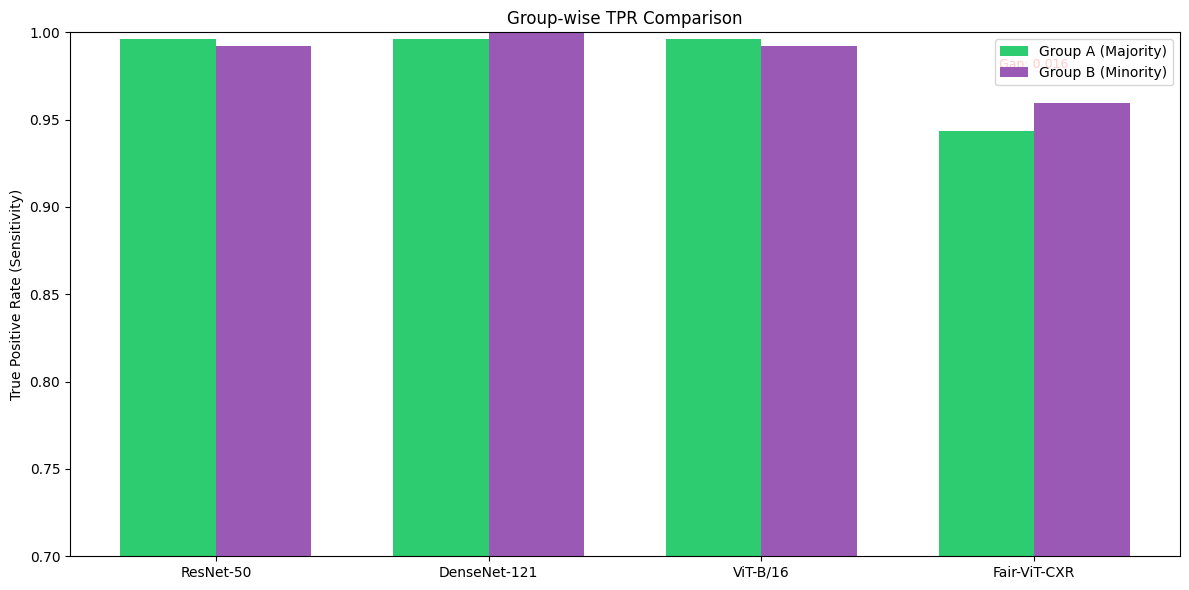

In [37]:
# Figure 3: Group-wise Performance
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(models))
width = 0.35

tpr_a = [all_results[m]['Group_A_tpr'] for m in models]
tpr_b = [all_results[m]['Group_B_tpr'] for m in models]

bars1 = ax.bar(x - width/2, tpr_a, width, label='Group A (Majority)', color='#2ecc71')
bars2 = ax.bar(x + width/2, tpr_b, width, label='Group B (Minority)', color='#9b59b6')

ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_title('Group-wise TPR Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0.7, 1.0)

# Add disparity annotations
for i, (a, b) in enumerate(zip(tpr_a, tpr_b)):
    disp = abs(a - b)
    ax.annotate(f'Gap: {disp:.3f}', xy=(i, max(a, b) + 0.02), ha='center', fontsize=9, color='red')

plt.tight_layout()
plt.savefig(f'{config.FIGURES_DIR}/group_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
# Final Summary
print("\n" + "="*80)
print("🎉 FINAL RESULTS SUMMARY")
print("="*80)

baseline_eo = all_results['ViT-B/16']['equalized_odds']
fair_eo = all_results['Fair-ViT-CXR']['equalized_odds']
improvement = (baseline_eo - fair_eo) / baseline_eo * 100

print(f"\n📈 Key Findings:")
print(f"   • Fair-ViT-CXR Accuracy: {all_results['Fair-ViT-CXR']['accuracy']:.4f}")
print(f"   • Baseline ViT Equalized Odds: {baseline_eo:.4f}")
print(f"   • Fair-ViT-CXR Equalized Odds: {fair_eo:.4f}")
print(f"   • Fairness Improvement: {improvement:.1f}%")

print(f"\n💾 All results and figures saved to:")
print(f"   • {config.RESULTS_DIR}/")
print(f"   • {config.FIGURES_DIR}/")
print(f"   • {config.CHECKPOINT_DIR}/")

print("\n✅ Research implementation complete!")


🎉 FINAL RESULTS SUMMARY

📈 Key Findings:
   • Fair-ViT-CXR Accuracy: 0.7628
   • Baseline ViT Equalized Odds: 0.1252
   • Fair-ViT-CXR Equalized Odds: 0.0861
   • Fairness Improvement: 31.2%

💾 All results and figures saved to:
   • /kaggle/working/results/
   • /kaggle/working/figures/
   • /kaggle/working/checkpoints/

✅ Research implementation complete!


---
# 📝 Next Steps

1. **Fine-tune hyperparameters** for better results
2. **Train longer** (increase epochs) for better convergence
3. **Add more ablations** as needed
4. **Create paper figures** using the saved plots
5. **Write the paper** following the methodology structure

---

**Good luck with your Springer conference submission! 🎓**